In [1]:
from itertools import product, islice
from typing import Dict, List, Any, Tuple, Callable
import os
import pickle
from timeit import default_timer as timer
import math

import numpy as np
import matplotlib.pyplot as plt

from IOData.IOData import InputRule
from IOData.IODataWith_l import IODataWith_l

from simulators.track_simulator import TrackSimulator
from simulators.simulation_settings import SafetyFilterTypes, TrackFilterTypes, SimulationInputRule, ModelType
from tools.simualtion_results import Results

from tools.simple_track_generator import trackGenerator
from tools.FractalDimension import fractal_dimension
from tools.monte_carlo_integral import monte_carlo_integrate
from tools.dataset_analyse import weighting_xi_in_datasets, weighting_u_pf_y_p_in_datasets, get_datasets_hankel_matrix, Sampler, from_deg_to_rad

In [2]:
# read results from file
results_file_name = '10-26_13_23-results_list.pkl'
with open(os.path.join(os.curdir, 'datasets', results_file_name), 'rb') as f:
    results_list: List[Results] = pickle.load(f)

In [3]:
dataset_name_list: List[str]  = [
    '10-26-12-48-24-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '10-26-12-54-32-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '10-26-13-01-13-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '10-26-13-08-53-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '10-26-13-16-41-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
]

In [4]:
len(dataset_name_list)

5

In [5]:
for result in results_list:
    print(result.mark_time_steps)
    # print([traj_slice[0] for traj_slice in result._error_trajectory_slices])
# print(round(5.32/0.01)-1)

[]
[]
[]
[]
[]
[347, 331, 311, 551, 535, 515]
[]
[]
[]
[1259, 1243, 1223]
[]
[]
[]
[]
[]
[947, 931, 911]
[]
[263, 247, 227]
[]
[51, 35, 15]
[]
[]
[]
[]


In [6]:
# parameters for analysis stored in Sampler
sampler = Sampler()
sampler.l_p = 10
sampler.l_f = 85

# results and dataset index to analyse
results_index = range(5, 24, 4)
dataset_list: List[List[List[IODataWith_l]]] = []
for i in range(len(dataset_name_list)):
    with open(os.path.join(os.curdir, 'datasets', dataset_name_list[i]), 'rb') as f:
        single_dataset_list: List[List[IODataWith_l]] = pickle.load(f)
    dataset_list.append(single_dataset_list)

# get output and input size
m = dataset_list[0][0][0]._input_data[0].shape[0]
p = dataset_list[0][0][0]._output_data[0].shape[0]

# # extended state to analyse
# state_index = 159
# results = results_list[results_index[0]]
# t_proposed = (state_index+1) * results.Ts
# u_list, y_list = [], []
# for i in range(state_index-sampler.l_p+1, state_index+1):
#     u_list.append(results._input_applied[i])
#     y_list.append(from_deg_to_rad(results._error_trajectory[i][:p]))
# xi_to_analyse = np.hstack(u_list + y_list)
# # print(xi_to_analyse)

# # extended state with future input to analyse. use the 
# u_future_list = []
# index_proposed = [trajectory_slice[0] for trajectory_slice in results._proposed_input_slices].index(t_proposed)
# list_proposed_u = results._proposed_input_slices[index_proposed][1]
# for i in range(sampler.l_f):
#     u_future_list.append(list_proposed_u[i])
# u_pf_y_p_to_analyse = np.hstack(u_list + u_future_list + y_list)
# # print(u_pf_y_p_to_analyse)

# # index of segment to analyse
# i_seg = results._segment_index_list[state_index]
# print(i_seg)

results_list_to_analyse = [results_list[i] for i in results_index]
# results_list_to_analyse = results_list
dataset_list_to_analyse = dataset_list
print(len(results_list_to_analyse))
print(len(dataset_list_to_analyse))
len(results_list_to_analyse[0]._error_trajectory_slices)

5
5


16

In [7]:
for result in results_list_to_analyse:
    print(len(result._predicted_error_with_slack_slices))
    error_list = np.ndarray(shape = (0,))
    for  prediction_with_slack, real_trajectory in zip(result._predicted_error_with_slack_slices, result._error_trajectory_slices):
        prediction_with_slack = np.hstack(prediction_with_slack[1][0:20])
        real_trajectory = np.hstack(real_trajectory[1][0:20])
        error_list = np.hstack((error_list, prediction_with_slack-real_trajectory))
    error = np.linalg.norm(error_list, ord=np.inf)
    print(error)

16
19.63518632514474
13
26.050887985758642
10
18.363316789291538
13
11.143952177054192
10
9.677191515067262


In [8]:
from tools.dataset_analyse import normalize_locs_list
from tools.FractalDimension import local_fractal_dimension

lag_fractal = 1
L_fractal = 0
i_seg = 0
locs_list = []
for datasets_for_segments in dataset_list:
    dataset_list_for_segment = datasets_for_segments[i_seg]
    H_uy_noised, _ = get_datasets_hankel_matrix(dataset_list_for_segment, lag=lag_fractal, L=L_fractal)
    locs = np.array(H_uy_noised[m:].T)
    print(locs.shape)
    region_min = np.min(locs, axis=0)
    region_max = np.max(locs, axis=0)
    locs = normalize_locs_list([locs], region_min, region_max)[0]
    locs_list.append(locs)

middle_points, fractal_dimension_list = local_fractal_dimension(locs_list)

(1332, 4)
(1616, 4)
(1892, 4)
(2172, 4)
(2460, 4)


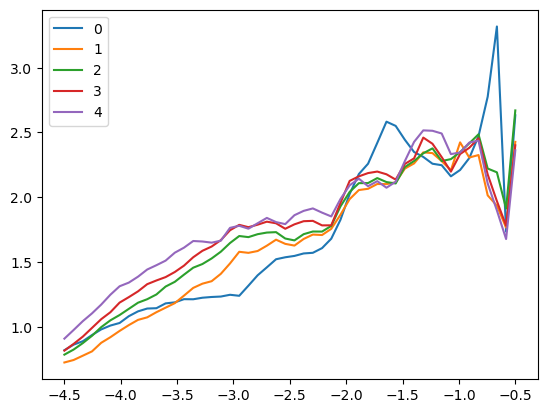

In [9]:
for i in range(len(fractal_dimension_list)):
    fractal_dimensions = fractal_dimension_list[i]
    plt.plot(middle_points, fractal_dimensions, label=f"{i}")
plt.legend()

(2460, 4)
0.9397026043374153


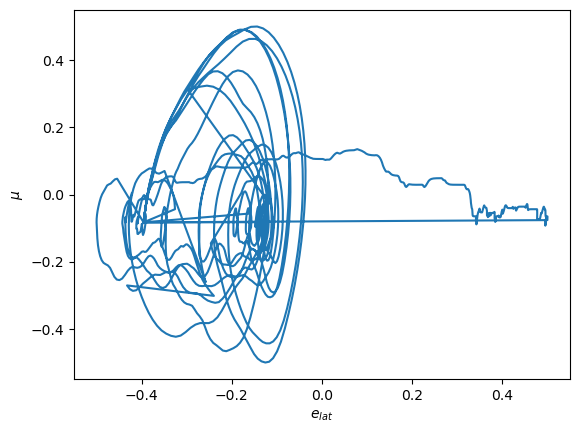

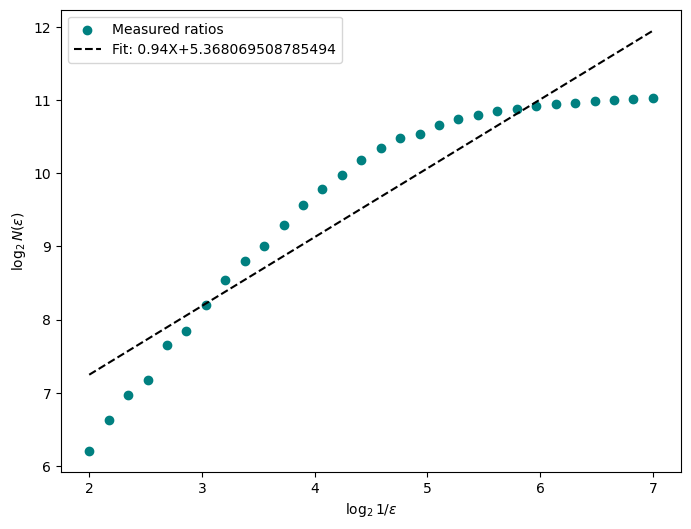

In [10]:
# from tools.dataset_analyse import normalize_locs_list

dataset_list_for_seg = dataset_list_to_analyse[-1][i_seg]
H_uy_noised, _ = get_datasets_hankel_matrix(dataset_list_for_seg, lag=lag_fractal, L=L_fractal)
locs = np.array(H_uy_noised[m:].T)
print(locs.shape)
plt.xlabel(r'$e_{lat}$')
plt.ylabel(r'$\mu$')

region_min = np.min(locs, axis=0)
region_max = np.max(locs, axis=0)
locs = normalize_locs_list([locs], region_min, region_max)[0]
plt.plot(locs[:,0], locs[:,1])
normalized_regin_min = np.min(locs, axis=0)
normalized_regin_max = np.max(locs, axis=0)

d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=normalized_regin_min, region_max=normalized_regin_max, max_box_size=-2, min_box_size=-7, n_samples=30, n_offsets=20, plot=True)
print(d)

1.608188641043603


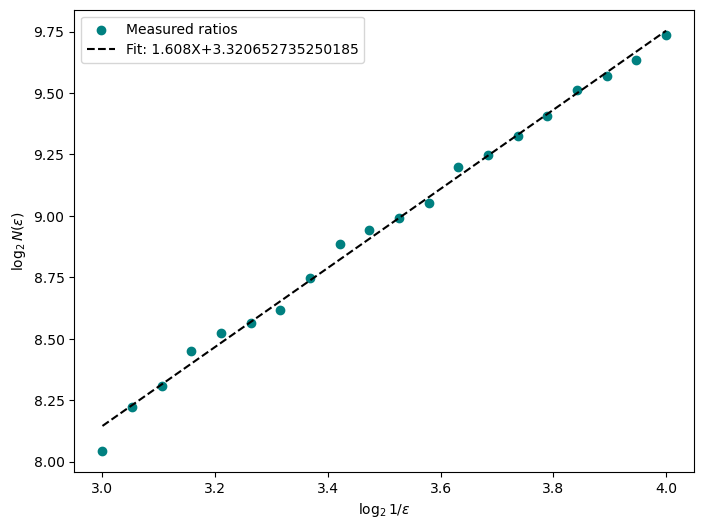

In [11]:
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=normalized_regin_min, region_max=normalized_regin_max, max_box_size=-3.0, min_box_size=-4.0, n_offsets=20, n_samples=20, plot=True)
print(d)

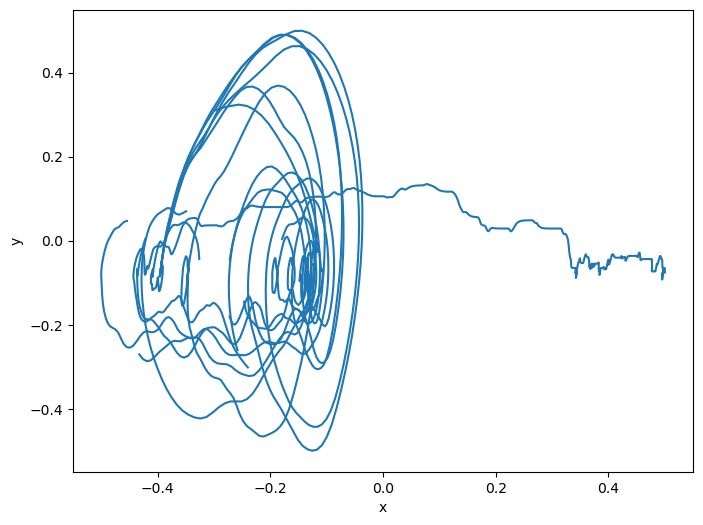

In [12]:
from tools.FractalDimension import plot_squares, plot_locs_list
from tools.dataset_analyse import get_datasets_hankel_matrix_list


H_uy_noised_list, _ = get_datasets_hankel_matrix_list(io_data_list=dataset_list_for_seg, lag=lag_fractal, L=L_fractal)
locs_list = [np.array(H_uy_noised[m:].T) for H_uy_noised in H_uy_noised_list]
locs_all = np.vstack(locs_list)
region_min = np.min(locs_all, axis=0)
region_max = np.max(locs_all, axis=0)
locs_list = normalize_locs_list(locs_list, region_min, region_max)
locs_all = np.vstack(locs_list)
normalized_regin_min = np.min(locs_all, axis=0)
normalized_regin_max = np.max(locs_all, axis=0)

plot_locs_list(locs_list)
# plot_squares(locs_list=locs_list, scale=-6, region_min=normalized_regin_min, region_max=normalized_regin_max, n_offsets=30)

In [31]:
from simulators.track_simulator import TrackSimulator
from tools.predictors import DynamicModelPredictor
from scipy.linalg import block_diag

simulator = TrackSimulator()
simulator.a_d_max = 2
simulator.delta_d_max = 0.12
simulator.use_saved_data = False
simulator.save_data = False
simulator.simulate_model_type = ModelType.DYNAMIC
simulator.data_model_type = ModelType.DYNAMIC
simulator.filter_model_type = ModelType.DYNAMIC
simulator.t_sim = 13.0
simulator.num_predicted_traj = 10
simulator.global_initial_state = np.array([0.0, 0.0, 0.0, 0.5, 0.0, 0.0])
simulator.cur = 1/1.0
simulator.track_fun_name = 'oval_track'
simulator.lag = 10
simulator.save_predicted_traj = True
simulator.save_dataset_after = True
simulator.delete_dataset_after = True
simulator.v_x_max = 2.7

simulator.t_data = 10.0
t_new_data = simulator.t_data * 0.6
simulator.data_input_rule = InputRule.PRBS_TIMES_RANDOM_MEAN

# simulator.n_v_max = 0
simulator.n_x, simulator.n_y, simulator.n_psi, simulator.n_v = 0,0,0,0
simulator.n_e_lat_max, simulator.n_mu_max, simulator.n_v_max, simulator.n_l_max = 0,0,0,0 # for test of prediction error

random_seed = 0
track_filter_type = TrackFilterTypes.SINGLE_SEGMENT
filter_type = SafetyFilterTypes.INDIRECT_FIX_MU_WEIGHTING_ADD_DATA
simulator.noise_list_dict = {}
simulator.random_seed = random_seed
simulator.noise_list_dict[random_seed] = simulator.get_noise()
simulator.track_filter_type = track_filter_type
simulator.filter_type_list = [filter_type] # reserve for using different filter types for segments
simulator.simulation_input_type = filter_type

simulator.get_utilities_for_simualtion(0)
systems = simulator.systems

lag = 10
weight_y = np.linalg.inv(np.diag([
    simulator.track_width*2,
    simulator.mu_max-simulator.mu_min,
    simulator.v_x_max-simulator.v_x_min,
    simulator.v_y_max-simulator.v_y_min,])**2)
weight_u = np.linalg.inv(np.diag([
    simulator.a_max-simulator.a_min,
    2*simulator.delta_max])**2)
weight_xi = np.matrix(block_diag(*((weight_u,)*lag + (weight_y,)*lag)))
predictor = DynamicModelPredictor(
    dynamic_error_model=systems[i_seg],
    sampler=Sampler(),
    L = 80,
    lag = lag,
    weight_xi = weight_xi,
    f = lambda d: 1/(1.1*d)**2,
    d_range = 0.1,
    min_num_slices = 450,
    portion_slices = 0.4,
    io_data_list = dataset_list_for_seg,
    weight_y=weight_y,
)

n_states = 50
n_datasets = len(dataset_list_to_analyse)
predictor.sample_state_and_input(n_states)

error_lists_datasets = np.empty(shape=(0, predictor.L))
plain_error_lists_datasets = np.empty(shape=(0, predictor.L))

for io_data_lists in dataset_list_to_analyse:
    predictor.io_data_list = io_data_lists[i_seg]

    predictor.f = lambda d: 1/(d)**2
    # predictor.f = lambda d: 1/d
    # predictor.f = lambda d: np.exp(-d**2)
    predictor.d_range = 0.1
    predictor.min_num_slices = 450
    predictor.portion_slices = 0.4
    state_error_list = predictor.get_prediction_error()
    mean_error_list = np.nanmean(state_error_list, axis=0)
    error_lists_datasets = np.vstack((error_lists_datasets, mean_error_list))

    predictor.f = lambda d: 1
    predictor.d_range = np.inf
    predictor.min_num_slices = 1
    predictor.portion_slices = 0.01
    plain_state_error_list = predictor.get_prediction_error()
    plain_mean_error_list = np.nanmean(plain_state_error_list, axis=0)
    plain_error_lists_datasets = np.vstack((plain_error_lists_datasets, plain_mean_error_list))
    # ax.plot(mean_error_list, label=f"{len(predictor.io_data_list)}")

/Users/huangyujun/Library/CloudStorage/OneDrive-ETHZurich/PersonalDocuments/2023SpringETH/DataDrivenSF/simulation/SafetyFilters/Indirect_Nominal_FixMu_Weighting_Add_Data.py:113: UserWarning: Given steps 4!
  warn(f"Given steps {params.sf_params.steps}!")
At t = 0.00195661, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.19698619  1.27112942 -0.52639338  0.27574812  5.05784029 -0.02285966]
input:  [[-0.87935696]
 [ 0.2030935 ]]


At t = 0.0044454, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [ 0.11718079  0.31628192 -0.56193615 -0.00218956 -0.73482107 -0.01465083]
input:  [[ 2.4579475 ]
 [-0.21052665]]


At t = 1.01297e-05, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.4224927  -0.90332918 -0.13528603  0.05127114  0.98599471 -0.00135638]
input:  [[ 2.50460792]
 [-0.050884  ]]


At t = 0.00138247, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-4.87017472e-01 -1.30541709e+00 -2.48077397e-01  2.08570704e-01
  3.78863006e+00  3.19196529e-03]
input:  [[ 3.08214597]
 [-0.10046423]]


At t = 0.00195661, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.19698619  1.27112942 -0.52639338  0.27574812  5.05784029 -0.02285966]
input:  [[-0.87935696]
 [ 0.2030935 ]]


At t = 0.0044454, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [ 0.11718079  0.31628192 -0.56193615 -0.00218956 -0.73482107 -0.01465083]
input:  [[ 2.4579475 ]
 [-0.21052665]]


At t = 1.01297e-05, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.4224927  -0.90332918 -0.13528603  0.05127114  0.98599471 -0.00135638]
input:  [[ 2.50460792]
 [-0.050884  ]]


At t = 0.00138247, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-4.87017472e-01 -1.30541709e+00 -2.48077397e-01  2.08570704e-01
  3.78863006e+00  3.19196529e-03]
input:  [[ 3.08214597]
 [-0.10046423]]


At t = 0.00195661, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.19698619  1.27112942 -0.52639338  0.27574812  5.05784029 -0.02285966]
input:  [[-0.87935696]
 [ 0.2030935 ]]


At t = 0.0044454, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [ 0.11718079  0.31628192 -0.56193615 -0.00218956 -0.73482107 -0.01465083]
input:  [[ 2.4579475 ]
 [-0.21052665]]


At t = 1.01297e-05, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.4224927  -0.90332918 -0.13528603  0.05127114  0.98599471 -0.00135638]
input:  [[ 2.50460792]
 [-0.050884  ]]


At t = 0.00138247, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-4.87017472e-01 -1.30541709e+00 -2.48077397e-01  2.08570704e-01
  3.78863006e+00  3.19196529e-03]
input:  [[ 3.08214597]
 [-0.10046423]]


At t = 0.00195661, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.19698619  1.27112942 -0.52639338  0.27574812  5.05784029 -0.02285966]
input:  [[-0.87935696]
 [ 0.2030935 ]]


At t = 0.0044454, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [ 0.11718079  0.31628192 -0.56193615 -0.00218956 -0.73482107 -0.01465083]
input:  [[ 2.4579475 ]
 [-0.21052665]]


At t = 1.01297e-05, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.4224927  -0.90332918 -0.13528603  0.05127114  0.98599471 -0.00135638]
input:  [[ 2.50460792]
 [-0.050884  ]]


At t = 0.00138247, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-4.87017472e-01 -1.30541709e+00 -2.48077397e-01  2.08570704e-01
  3.78863006e+00  3.19196529e-03]
input:  [[ 3.08214597]
 [-0.10046423]]


At t = 0.00195661, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.19698619  1.27112942 -0.52639338  0.27574812  5.05784029 -0.02285966]
input:  [[-0.87935696]
 [ 0.2030935 ]]


At t = 0.0044454, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [ 0.11718079  0.31628192 -0.56193615 -0.00218956 -0.73482107 -0.01465083]
input:  [[ 2.4579475 ]
 [-0.21052665]]


At t = 1.01297e-05, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.4224927  -0.90332918 -0.13528603  0.05127114  0.98599471 -0.00135638]
input:  [[ 2.50460792]
 [-0.050884  ]]


At t = 0.00138247, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-4.87017472e-01 -1.30541709e+00 -2.48077397e-01  2.08570704e-01
  3.78863006e+00  3.19196529e-03]
input:  [[ 3.08214597]
 [-0.10046423]]


At t = 0.00195661, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.19698619  1.27112942 -0.52639338  0.27574812  5.05784029 -0.02285966]
input:  [[-0.87935696]
 [ 0.2030935 ]]


At t = 0.0044454, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [ 0.11718079  0.31628192 -0.56193615 -0.00218956 -0.73482107 -0.01465083]
input:  [[ 2.4579475 ]
 [-0.21052665]]


At t = 1.01297e-05, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.4224927  -0.90332918 -0.13528603  0.05127114  0.98599471 -0.00135638]
input:  [[ 2.50460792]
 [-0.050884  ]]


At t = 0.00138247, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-4.87017472e-01 -1.30541709e+00 -2.48077397e-01  2.08570704e-01
  3.78863006e+00  3.19196529e-03]
input:  [[ 3.08214597]
 [-0.10046423]]


At t = 0.00195661, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.19698619  1.27112942 -0.52639338  0.27574812  5.05784029 -0.02285966]
input:  [[-0.87935696]
 [ 0.2030935 ]]


At t = 0.0044454, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [ 0.11718079  0.31628192 -0.56193615 -0.00218956 -0.73482107 -0.01465083]
input:  [[ 2.4579475 ]
 [-0.21052665]]


At t = 1.01297e-05, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.4224927  -0.90332918 -0.13528603  0.05127114  0.98599471 -0.00135638]
input:  [[ 2.50460792]
 [-0.050884  ]]


At t = 0.00138247, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-4.87017472e-01 -1.30541709e+00 -2.48077397e-01  2.08570704e-01
  3.78863006e+00  3.19196529e-03]
input:  [[ 3.08214597]
 [-0.10046423]]


At t = 0.00195661, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.19698619  1.27112942 -0.52639338  0.27574812  5.05784029 -0.02285966]
input:  [[-0.87935696]
 [ 0.2030935 ]]


At t = 0.0044454, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [ 0.11718079  0.31628192 -0.56193615 -0.00218956 -0.73482107 -0.01465083]
input:  [[ 2.4579475 ]
 [-0.21052665]]


At t = 1.01297e-05, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.4224927  -0.90332918 -0.13528603  0.05127114  0.98599471 -0.00135638]
input:  [[ 2.50460792]
 [-0.050884  ]]


At t = 0.00138247, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-4.87017472e-01 -1.30541709e+00 -2.48077397e-01  2.08570704e-01
  3.78863006e+00  3.19196529e-03]
input:  [[ 3.08214597]
 [-0.10046423]]


At t = 0.00195661, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.19698619  1.27112942 -0.52639338  0.27574812  5.05784029 -0.02285966]
input:  [[-0.87935696]
 [ 0.2030935 ]]


At t = 0.0044454, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [ 0.11718079  0.31628192 -0.56193615 -0.00218956 -0.73482107 -0.01465083]
input:  [[ 2.4579475 ]
 [-0.21052665]]


At t = 1.01297e-05, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.4224927  -0.90332918 -0.13528603  0.05127114  0.98599471 -0.00135638]
input:  [[ 2.50460792]
 [-0.050884  ]]


At t = 0.00138247, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-4.87017472e-01 -1.30541709e+00 -2.48077397e-01  2.08570704e-01
  3.78863006e+00  3.19196529e-03]
input:  [[ 3.08214597]
 [-0.10046423]]


At t = 0.00195661, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.19698619  1.27112942 -0.52639338  0.27574812  5.05784029 -0.02285966]
input:  [[-0.87935696]
 [ 0.2030935 ]]


At t = 0.0044454, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [ 0.11718079  0.31628192 -0.56193615 -0.00218956 -0.73482107 -0.01465083]
input:  [[ 2.4579475 ]
 [-0.21052665]]


At t = 1.01297e-05, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-0.4224927  -0.90332918 -0.13528603  0.05127114  0.98599471 -0.00135638]
input:  [[ 2.50460792]
 [-0.050884  ]]


At t = 0.00138247, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

Error occured when propogating real system:
state:  [-4.87017472e-01 -1.30541709e+00 -2.48077397e-01  2.08570704e-01
  3.78863006e+00  3.19196529e-03]
input:  [[ 3.08214597]
 [-0.10046423]]


(0.0, 3000000.0)

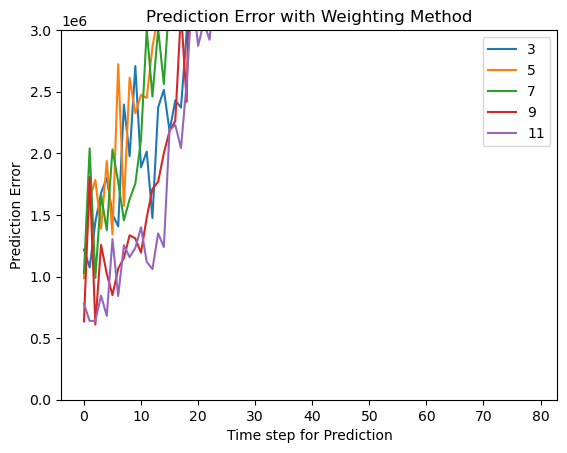

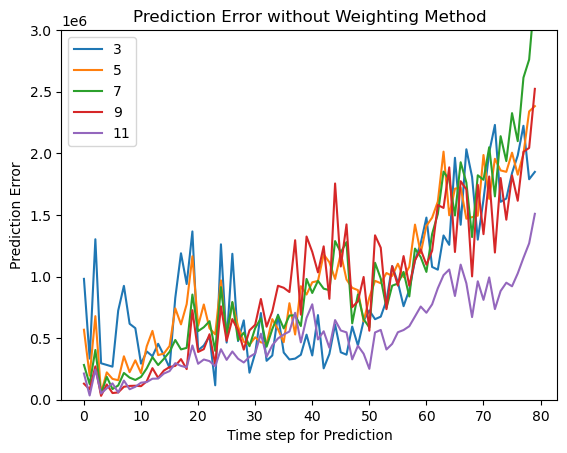

In [32]:
fig, ax = plt.subplots()
for i in range(n_datasets):
    ax.plot(error_lists_datasets[i], label=f"{len(dataset_list_to_analyse[i][i_seg])}")

ax.legend()
ax.set_xlabel("Time step for Prediction")
ax.set_ylabel("Prediction Error")
ax.set_title("Prediction Error with Weighting Method")
ax.set_ylim([0, 0.3e7])

fig, ax = plt.subplots()
for i in range(n_datasets):
    ax.plot(plain_error_lists_datasets[i], label=f"{len(dataset_list_to_analyse[i][i_seg])}")

ax.legend()
ax.set_xlabel("Time step for Prediction")
ax.set_ylabel("Prediction Error")
ax.set_title("Prediction Error without Weighting Method")
ax.set_ylim([0, 0.3e7])

In [16]:
# parameters used for analysing dataset

size_xi = len(xi_to_analyse)
size_uy = len(u_pf_y_p_to_analyse)
print(size_xi, size_uy)

W_xi = np.matrix(np.eye(size_xi))
W_uy = np.matrix(np.eye(size_uy))
f = lambda x: 0.01/x

lag = 10
L = 85

weighting_xi_list: List[float] = []
weighting_uy_list: List[float] = []
for dataset_list_for_track in dataset_list:
    dataset_list_for_seg = dataset_list_for_track[i_seg]
    print([data.length for data in dataset_list_for_seg])

    # evalueate the weighting matrix for xi
    weighting_xi = weighting_xi_in_datasets(W_xi=W_xi, f=f, io_data_list=dataset_list_for_seg, lag=lag, L=L, l_p=sampler.l_p, l_f=sampler.l_f, xi=xi_to_analyse)
    weighting_xi_list.append(weighting_xi)
    print(f"The weight of xi: {weighting_xi}")

    # evalueate the weighting matrix for u_pf_y_p
    weighting_uy = weighting_u_pf_y_p_in_datasets(W=W_uy, f=f, io_data_list=dataset_list_for_seg, lag=lag, L=L, l_p=sampler.l_p, l_f=sampler.l_f, u_pf_y_p=u_pf_y_p_to_analyse)
    weighting_uy_list.append(weighting_uy)
    print(f"The weight of u_pf_y_p: {weighting_uy}")

    # try monte carlo integral
    # start = timer()
    values = []
    errors = []
    for n in [5, 100, 10000]:
        integrand = lambda x: weighting_xi_in_datasets(W_xi=W_xi, f=f, io_data_list=dataset_list_for_seg, lag=lag, L=L, l_p=sampler.l_p, l_f=sampler.l_f, xi=x)
        value, error = monte_carlo_integrate(integrand, sampler.xi_iterator(), n=n)
        values.append(value)
        errors.append(error)
        print((value, error))
    print(f"Value for xi integral: {values}, error: {errors}")
    # end = timer()
    # print(f"Time for xi integral: {end-start}")

    # start = timer()
    values = []
    errors = []
    for n in [5, 10, 100, 10000]:
        integrand = lambda x: weighting_u_pf_y_p_in_datasets(W=W_uy, f=f, io_data_list=dataset_list_for_seg, lag=lag, L=L, l_p=sampler.l_p, l_f=sampler.l_f, u_pf_y_p=x)
        value, error = monte_carlo_integrate(integrand, sampler.u_pf_y_p_iterator(), n=n)
        values.append(value)
        errors.append(error)
        print((value, error))
    print(f"Value for u_pf_y_p integral: {values}, error: {errors}")
    # end = timer()
    # print(f"Time for u_pf_y_p integral: {end-start}")
    print("--------------------------------------------------")


NameError: name 'xi_to_analyse' is not defined